## M.orygis genome analysis

links:

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3647658/
* http://bacteria.ensembl.org/Mycobacterium_orygis_112400015/Info/Index
* https://www.frontiersin.org/articles/10.3389/fmicb.2018.02820/full
* https://www.ncbi.nlm.nih.gov/assembly/?term=mycobacterium+orygis

In [147]:
import os, sys, io, random, subprocess
import string
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import seaborn as sns
sns.set_context("talk")
import pylab as plt
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis


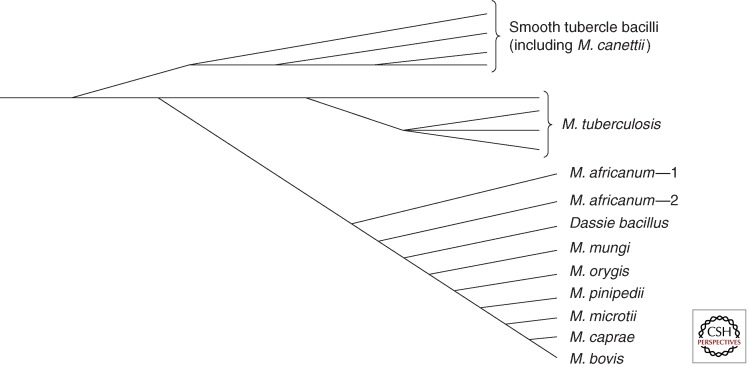

In [148]:
Image('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315922/bin/cshperspectmed-TUB-021204_F2.jpg')

## run nucdiff

In [164]:
path = '../test_genomes'
#names = ['Mbovis','Morygis','Mcaprae','Mmicroti','Mpinnipedii','Mcanettii','Mafricanum']
names = analysis.run_genomes(path, outpath='../test_results')

../test_genomes/Mbovis.fna Mbovis
folder already present
../test_genomes/Mmungi_BM22813.fna Mmungi_BM22813
folder already present
../test_genomes/BCG_Pasteur.fna BCG_Pasteur
folder already present
../test_genomes/MTB_beijing.fna MTB_beijing
folder already present
../test_genomes/Mcanettii.fna Mcanettii
folder already present
../test_genomes/Morygis_Resp2011.fna Morygis_Resp2011
folder already present
../test_genomes/Mafricanum.fna Mafricanum
folder already present
../test_genomes/Mpinnipedii.fna Mpinnipedii
folder already present
../test_genomes/Mcaprae.fna Mcaprae
folder already present
../test_genomes/MTB_ethiopia.fna MTB_ethiopia
nucdiff /home/farrell/gitprojects/mtbdiff/mtbdiff/data/MTB-H37Rv.fna ../test_genomes/MTB_ethiopia.fna ../test_results/MTB-H37Rv_MTB_ethiopia query
../test_genomes/Morygis_LN2011.fna Morygis_LN2011
folder already present
../test_genomes/Morygis_112400015.fna Morygis_112400015
folder already present
../test_genomes/Mmicroti.fna Mmicroti
folder already present

In [165]:
def get_annotations(x, feat):
    """Get annotations from sets of coords in a dataframe (start, end)
    This is a vectorised function to be applied on rows"""
    
    found = mtb_feat[((mtb_feat.start<x.start) & (mtb_feat.end>x.end)) |
                      ((mtb_feat.start>x.start) & (mtb_feat.end<x.end)) |
                      ((mtb_feat.end>x.start) & (mtb_feat.end<x.end))]   
    if len(found)>0:
        #print (found)
        return list(found.gene)
    
RD = pd.read_csv(utils.RD_file,comment='#')
def get_region(x, stcoord='start', endcoord='end'):
    """Get an overlapping RD from coord"""
    
    st = x[stcoord]; end = x[endcoord]
    found = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))]
    if len(found)>0:
        return found.iloc[0].RD_name

def get_mtb_gff():
    gff_file = analysis.mtb_gff
    feat = utils.gff_to_dataframe(gff_file)
    feat = feat[feat.gbkey=='Gene']
    return feat

#struct['RD'] = struct.apply(get_region,1)

## get nucdiff results
* get RD regions
* get protein annotations

In [166]:
reload(utils)
print (names)
mtb_feat = get_mtb_gff()
struct, snp =  utils.get_nucdiff_results('../test_results', names)
#remove reshuffling events?
struct = struct[~struct.Name.str.contains('reshuffling')]
struct['RD'] = struct.apply(get_region,1)
struct['gene'] = struct.apply(lambda x: get_annotations(x, mtb_feat), 1)

subcols = ['ID','Name','start','end','length','descr','RD','gene']
print (struct[:4][subcols])

['Mbovis', 'Mmungi_BM22813', 'BCG_Pasteur', 'MTB_beijing', 'Mcanettii', 'Morygis_Resp2011', 'Mafricanum', 'Mpinnipedii', 'Mcaprae', 'MTB_ethiopia', 'Morygis_LN2011', 'Morygis_112400015', 'Mmicroti', 'Morygis_Absc2007', 'Morygis_Resp2008', 'Morygis_NIRTAH144']
     ID         Name   start     end  length                      descr    RD        gene
1  SV_2    insertion   71585   71586       1      insertion_71585:71586  None        None
2  SV_3  duplication   71585   71586       1    duplication_71585:71586  None        None
3  SV_4    insertion  150902  150903       1    insertion_150902:150903  None  [PE_PGRS2]
4  SV_5  duplication  150902  150903       1  duplication_150902:150903  None  [PE_PGRS2]


## presence/absence matrix of events

In [167]:
def sites_matrix(struct, index=['start','end'], freq=0):
    """Pivot by start site"""
    X = pd.pivot_table(struct,index=index,columns=['label'],values='Name',aggfunc='first')
    X[X.notnull()] = 1
    X = X.fillna(0)
    #remove unique?    
    X = X[X.sum(1)>freq]
    return X

def RD_matrix(struct):
    #pivot by presence of RDs
    X = pd.pivot_table(struct,index=['RD'],columns=['label'],values='Name',aggfunc='count')
    X[X.notnull()] = 1
    X = X.fillna(0)  
    return X

s = struct[(struct.Name=='deletion') | (struct.Name=='insertion')]
rdmat = RD_matrix(struct)
smat = sites_matrix(s, freq=2)
#snpmat = sites_matrix(snps, freq=5)

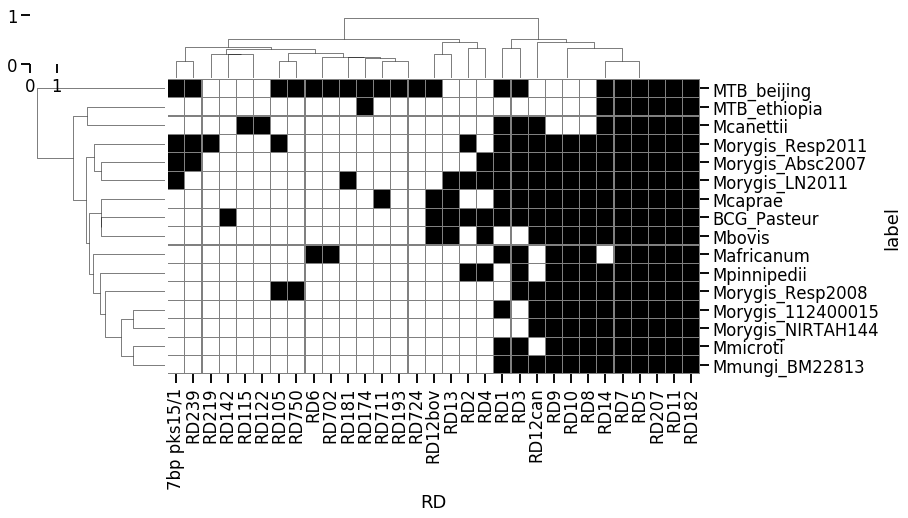

In [168]:
def plot_RD(df):
    h=len(df)/10+5
    cl=sns.clustermap(df,cbar=False,figsize=(12,h),lw=.2,linecolor='gray',cmap='gray_r',yticklabels=True)
    #cl.savefig(path)    
    return cl

#rds = utils.find_regions(struct)
#x=run_RD_checker(rds)
#plot_RD(x)
fig=plot_RD(rdmat.T)
fig.savefig('RD_matrix.png',dpi=150)

## find RDs

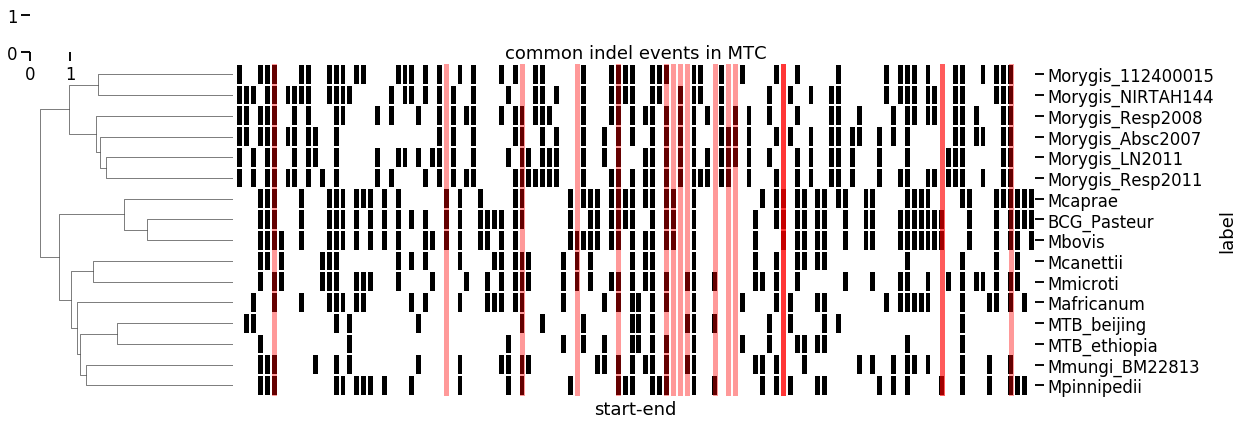

In [170]:
def map_regions(coords):
    """Map list of coords to regions of difference and return a dataframe"""
    
    m = []
    RD = pd.read_csv(utils.RD_file,comment='#')
    for c in coords:
        st,end=c
        df = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))].copy()
        if len(df)>0:
            #print (df)            
            df['start'] = st
            df['end'] = end
            m.append(df)
    m=pd.concat(m)
    return m

m = map_regions(smat.index.values)
#get positions on heatmap of these start locs
#print (m)
xpos = [smat.index.get_loc(i) for i in zip(m.start,m.end)]
labels = list(m.RD_name)
#print (xpos,labels)

#plot heatmap
g=sns.clustermap(smat.T,cbar=False,figsize=(18,7),xticklabels=False,col_cluster=False,cmap='gray_r',lw=1)
ax=g.ax_heatmap
ax.set_title('common indel events in MTC')
for x in xpos:
    ax.axvline(x=x+.5,linewidth=5,color='r',alpha=0.4)
    
plt.sca(ax)
#plt.xticks(xpos, labels)
#l=ax.set_xticklabels(labels,rotation=45)

## check we are detecting RDs properly?

In [ ]:
rx = struct[(struct.label=='Mmicroti') & (~struct.RD.isnull())]
print (rx[cols])

## Compare struct changes between mbovis and orygis 

* get common start sites between the orygis and bovis samples
* common snps?

1871
44 common sites


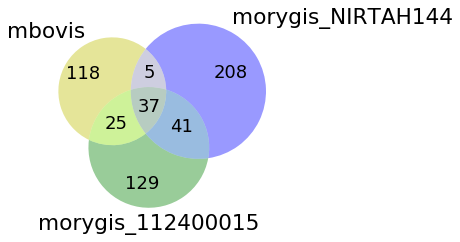

In [171]:
reload(utils)

#print (struct.label.unique())
subset = ['Mbovis', 'Morygis_NIRTAH144','Morygis_112400015','Morygis_LN2011','Morygis_Resp2011']
mb_oryg = struct[struct.label.isin(subset)]
print (len(mb_oryg))
mbdiff = struct[struct.label=='Mbovis']
modiff = struct[struct.label=='Morygis_NIRTAH144']
modiff2 = struct[struct.label=='Morygis_112400015']

from matplotlib_venn import venn3
ax=venn3((set(mbdiff.descr),set(modiff.descr),set(modiff2.descr)),['mbovis','morygis_NIRTAH144','morygis_112400015'],('y','b','g'))

mat = sites_matrix(mb_oryg, index='descr')
mat = mat[mat.sum(1)>3]
intersect = mat.index

comm = modiff[modiff.descr.isin(intersect)]
comm = comm[subcols]
print('%s common sites' %len(comm))
#print (comm.groupby('Name').size())

In [139]:
comm=comm.sort_values('length',ascending=False)
comm.to_csv('morygis_common.csv')
comm

,ID,Name,start,end,length,descr,RD,gene
307,SV_97,deletion,4056840,4062733,5893,deletion_4056840:4062733,RD8,"[ephA, Rv3618, esxV, esxW, PPE65, PE32]"
172,SV_204,deletion,2330073,2332101,2028,deletion_2330073:2332101,RD9,"[cobL, Rv2073c, Rv2074]"
10,SV_137,deletion,264754,266656,1902,deletion_264754:266656,RD10,"[Rv0221, echA1]"
24,SV_211,deletion,365264,367097,1833,deletion_365264:367097,None,[Rv0303]
280,SV_171,deletion,3890778,3892133,1355,deletion_3890778:3892133,None,None
267,SV_79,deletion,3795057,3796412,1355,deletion_3795057:3796412,None,None
184,SV_44,deletion,2430116,2431471,1355,deletion_2430116:2431471,None,None
180,SV_48,deletion,2365414,2366768,1354,deletion_2365414:2366768,None,None
203,SV_20,deletion,2784616,2785969,1353,deletion_2784616:2785969,None,None
117,SV_72,deletion,1572338,1573418,1080,deletion_1572338:1573418,None,[PE_PGRS25]


In [ ]:
struct.columns
x = pd.pivot_table(struct, index='Name',columns=['species'],aggfunc='count')
x=x.fillna(0)
x

## look at features on the genome viewer

In [198]:
reload(viewers)
gff1 = analysis.mtb_gff
gff2 = '../test_results/MTB-H37Rv_Mbovis/results/query_ref_struct.gff'
feats = utils.gff_to_features(gff2)
p=viewers.view_features(feats)
p

(1, 20000) 5000


Column
    [0] Row
        [0] TextInput(name='gff file')
        [1] TextInput(name='location', value='1:20000', width=200)
        [2] TextInput(name='find_gene', width=200)
        [3] Button(button_type='primary', name='-', width=40)
        [4] Str(int, style={'margin': '4pt'}, width=180)
    [1] IntRangeSlider(end=1000000, step=10, value=(1, 20000), width=900)
    [2] Column(sizing_mode='stretch_width')
        [0] Bokeh(Figure, height=100, margin=10)